<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/exercises/P1-MovieGenrePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Movie Genre Classification

Classify a movie genre based on its plot.

<img src="https://raw.githubusercontent.com/sergiomora03/AdvancedTopicsAnalytics/main/notebooks/img/moviegenre.png"
     style="float: left; margin-right: 10px;" />



### Data

Input:
- movie plot

Output:
Probability of the movie belong to each genre


### Evaluation

- 30% Report with all the details of the solution, the analysis and the conclusions. The report cannot exceed 10 pages, must be send in PDF format and must be self-contained.
- 30% Code with the data processing and models developed that support the reported results.
- 30% Presentation of no more than 15 minutes with the main results of the project.
- 10% Model performance achieved. Metric: "AUC".

• The project must be carried out in groups of 4 people.
• Use clear and rigorous procedures.
• The delivery of the project is on March 15th, 2024, 11:59 pm, through email with Github link.
• No projects will be received after the delivery time or by any other means than the one established.




### Acknowledgements

We thank Professor Fabio Gonzalez, Ph.D. and his student John Arevalo for providing this dataset.

See https://arxiv.org/abs/1702.01992

# Sample Submission

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
import gensim
from gensim.models import Word2Vec

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
dataTraining = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [ ]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [ ]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


# Create y

In [ ]:
# Creación de matriz binaria, columnas corresponden a los géneros y las filas a las películas

dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])
y_genres.shape

(7895, 24)

# Estrategia 1: Métodos de vectorización básicos

## Lemmatizing o Stemming

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english')
stop_words = set(stopwords.words('english'))

def preprocess_text_lemm(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    tokens = [lemmatizer.lemmatize(token) for token in tokens] #Lemmatizing
    return ' '.join(tokens)

def preprocess_text_stem(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    tokens = [stemmer.stem(token) for token in tokens] #Stemming
    return ' '.join(tokens)

In [ ]:
dataTraining['plot_lemm'] = dataTraining['plot'].apply(preprocess_text_lemm)
dataTraining['plot_stem'] = dataTraining['plot'].apply(preprocess_text_stem)

## RandomForest

In [ ]:
Bool_CountVectorized = False #CountVectorized if True, TfidfVectorizer if False

In [ ]:
df_values = []
roc_auc_scores = []
roc_auc_scores_lemm = []
roc_auc_scores_stem = []

for i in range(1, 11):
    df_values.append(i)

    if Bool_CountVectorized == True:
        vect = CountVectorizer(stop_words='english', min_df=i, ngram_range=(1,1))
    else:
        vect = TfidfVectorizer(stop_words='english', min_df=i, ngram_range=(1,1))

    # Transformar los datos
    X_dtm = vect.fit_transform(dataTraining['plot'])
    X_dtm_lemm = vect.fit_transform(dataTraining['plot_lemm'])
    X_dtm_stem = vect.fit_transform(dataTraining['plot_stem'])

    # Dividir los datos en conjunto de entrenamiento y prueba
    X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)
    X_train_lemm, X_test_lemm, y_train_genres_lemm, y_test_genres_lemm = train_test_split(X_dtm_lemm, y_genres, test_size=0.33, random_state=42)
    X_train_stem, X_test_stem, y_train_genres_stem, y_test_genres_stem = train_test_split(X_dtm_stem, y_genres, test_size=0.33, random_state=42)

    # Modelo con trama original
    clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=200, max_depth=15, random_state=42))
    clf.fit(X_train, y_train_genres)
    y_pred_genres = clf.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test_genres, y_pred_genres, average='macro')
    roc_auc_scores.append(roc_auc)

    print(f"ROC AUC for df = {i}: {roc_auc} con {X_dtm.shape[1]} palabras")

    # Modelo con trama lemmatized
    clf_lemm = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=200, max_depth=15, random_state=42))
    clf_lemm.fit(X_train_lemm, y_train_genres_lemm)
    y_pred_genres_lemm = clf_lemm.predict_proba(X_test_lemm)
    roc_auc_lemm = roc_auc_score(y_test_genres_lemm, y_pred_genres_lemm, average='macro')
    roc_auc_scores_lemm.append(roc_auc_lemm)

    print(f"ROC AUC lemm for df = {i}: {roc_auc_lemm} con {X_dtm_lemm.shape[1]} palabras")

    # Modelo con trama stemmed
    clf_stem = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=200, max_depth=15, random_state=42))
    clf_stem.fit(X_train_stem, y_train_genres_stem)
    y_pred_genres_stem = clf_stem.predict_proba(X_test_stem)
    roc_auc_stem = roc_auc_score(y_test_genres_stem, y_pred_genres_stem, average='macro')
    roc_auc_scores_stem.append(roc_auc_stem)

    print(f"ROC AUC stem for df = {i}: {roc_auc_stem} con {X_dtm_stem.shape[1]} palabras")

In [ ]:
# Mejores auc según procesamiento
print('roc_auc_score: ', max(roc_auc_scores))
print('roc_auc_score_lemm', max(roc_auc_scores_lemm))
print('roc_auc_score_stem', max(roc_auc_scores_stem))

In [ ]:
# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(df_values, roc_auc_scores, linestyle='-', marker='o', color='green', label='ROC_AU')
plt.plot(df_values, roc_auc_scores_lemm, linestyle='-', marker='o', color='orange', label='ROC_AU_lemm')
plt.plot(df_values, roc_auc_scores_stem, linestyle='-', marker='o', color='blue', label='ROC_AU_stem')

# # Añadir etiquetas de texto a cada punto en el gráfico
# for i, roc_auc in enumerate(roc_auc_scores):
#     plt.text(df_values[i], roc_auc, f"{roc_auc:.4f}", fontsize=10, verticalalignment='bottom', horizontalalignment='center')
# for i, roc_auc_lemm in enumerate(roc_auc_scores_lemm):
#     plt.text(df_values[i], roc_auc_lemm, f"{roc_auc_lemm:.4f}", fontsize=10, verticalalignment='top', horizontalalignment='center')
# for i, roc_auc_stem in enumerate(roc_auc_scores_stem):
#     plt.text(df_values[i], roc_auc_stem, f"{roc_auc_stem:.4f}", fontsize=10, verticalalignment='bottom', horizontalalignment='right')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('df',fontsize=16)
plt.ylabel('Roc auc score', fontsize=16)
#plt.title('roc auc score Vs df',fontsize=16)
plt.grid(axis='y', color='0.90')
plt.legend(loc=(0.71,0.02), fontsize=14)
plt.show()

In [ ]:
# df_values = []
# roc_auc_scores_lemm = []
# roc_auc_scores_stem = []

# for i in range(1,11):
#     #print(i/10,'% :', round(7895*(i/1000)))

#     if Bool_CountVectorized == True:
#         vect = CountVectorizer(stop_words='english', min_df=round(7895*(i/100)), ngram_range=(1,1))
#     else:
#         vect = TfidfVectorizer(stop_words='english', min_df=round(7895*(i/100)), ngram_range=(1,1))

#     df_values.append(round(7895*(i/100)))
#     # Transformar los datos
#     X_dtm_lemm = vect.fit_transform(dataTraining['plot_lemm'])
#     X_dtm_stem = vect.fit_transform(dataTraining['plot_stem'])
#     #print(X_dtm.shape)

#     # Dividir los datos en conjunto de entrenamiento y prueba
#     X_train_lemm, X_test_lemm, y_train_genres_lemm, y_test_genres_lemm = train_test_split(X_dtm_lemm, y_genres, test_size=0.33, random_state=42)
#     X_train_stem, X_test_stem, y_train_genres_stem, y_test_genres_stem = train_test_split(X_dtm_stem, y_genres, test_size=0.33, random_state=42)

#     # Modelo, predicción y calculo de roc_auc_score
#     clf_lemm = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=200, max_depth=15, random_state=42))
#     clf_lemm.fit(X_train_lemm, y_train_genres_lemm)
#     y_pred_genres_lemm = clf_lemm.predict_proba(X_test_lemm)
#     roc_auc_lemm = roc_auc_score(y_test_genres_lemm, y_pred_genres_lemm, average='macro')
#     roc_auc_scores_lemm.append(roc_auc_lemm)

#     #print(f"ROC AUC lemm for df = {i}: {roc_auc_lemm} con {X_dtm_lemm.shape[1]} palabras")

#     clf_stem = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=200, max_depth=15, random_state=42))
#     clf_stem.fit(X_train_stem, y_train_genres_stem)
#     y_pred_genres_stem = clf_stem.predict_proba(X_test_stem)
#     roc_auc_stem = roc_auc_score(y_test_genres_stem, y_pred_genres_stem, average='macro')
#     roc_auc_scores_stem.append(roc_auc_stem)

#     #print(f"ROC AUC stem for df = {i}: {roc_auc_stem} con {X_dtm_stem.shape[1]} palabras")

# # Graficar los resultados
# plt.figure(figsize=(10, 6))
# plt.plot(df_values, roc_auc_scores_lemm, linestyle='-', marker='o', color='orange', label='ROC_AU_lemm')
# plt.plot(df_values, roc_auc_scores_stem, linestyle='-', marker='o', color='blue', label='ROC_AU_stem')

# #Añadir etiquetas de texto a cada punto en el gráfico
# for i, roc_auc_lemm in enumerate(roc_auc_scores_lemm):
#     plt.text(df_values[i], roc_auc_lemm, f"{roc_auc_lemm:.5f}", fontsize=10, verticalalignment='top', horizontalalignment='center')
# for i, roc_auc_stem in enumerate(roc_auc_scores_stem):
#     plt.text(df_values[i], roc_auc_stem, f"{roc_auc_stem:.5f}", fontsize=10, verticalalignment='bottom', horizontalalignment='center')

# plt.xlabel('df')
# plt.ylabel('Roc auc score')
# plt.title('Roc auc score según df')
# plt.grid(axis='y', color='0.95')
# plt.legend(loc='lower right')
# plt.show()

## XGBoost

In [ ]:
Bool_CountVectorized = False #CountVectorized if True, TfidfVectorizer if False

In [ ]:
df_values = []
roc_auc_scores = []
roc_auc_scores_lemm = []
roc_auc_scores_stem = []

for i in range(1, 11):
    df_values.append(i)

    if Bool_CountVectorized == True:
        vect = CountVectorizer(stop_words='english', min_df=i, ngram_range=(1,1))
    else:
        vect = TfidfVectorizer(stop_words='english', min_df=i, ngram_range=(1,1))

    # Transformar los datos
    X_dtm = vect.fit_transform(dataTraining['plot'])
    X_dtm_lemm = vect.fit_transform(dataTraining['plot_lemm'])
    X_dtm_stem = vect.fit_transform(dataTraining['plot_stem'])

    # Dividir los datos en conjunto de entrenamiento y prueba
    X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)
    X_train_lemm, X_test_lemm, y_train_genres_lemm, y_test_genres_lemm = train_test_split(X_dtm_lemm, y_genres, test_size=0.33, random_state=42)
    X_train_stem, X_test_stem, y_train_genres_stem, y_test_genres_stem = train_test_split(X_dtm_stem, y_genres, test_size=0.33, random_state=42)

    # Modelo con trama original
    clf = OneVsRestClassifier(XGBClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42, eval_metric='mlogloss'))
    clf.fit(X_train, y_train_genres)
    y_pred_genres = clf.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test_genres, y_pred_genres, average='macro')
    roc_auc_scores.append(roc_auc)

    print(f"ROC AUC for df = {i}: {roc_auc} con {X_dtm.shape[1]} palabras")

    # Modelo con trama lemmatized
    clf_lemm = OneVsRestClassifier(XGBClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42, eval_metric='mlogloss'))
    clf_lemm.fit(X_train_lemm, y_train_genres_lemm)
    y_pred_genres_lemm = clf_lemm.predict_proba(X_test_lemm)
    roc_auc_lemm = roc_auc_score(y_test_genres_lemm, y_pred_genres_lemm, average='macro')
    roc_auc_scores_lemm.append(roc_auc_lemm)

    print(f"ROC AUC lemm for df = {i}: {roc_auc_lemm} con {X_dtm_lemm.shape[1]} palabras")

    # Modelo con trama stemmed
    clf_stem = OneVsRestClassifier(XGBClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42, eval_metric='mlogloss'))
    clf_stem.fit(X_train_stem, y_train_genres_stem)
    y_pred_genres_stem = clf_stem.predict_proba(X_test_stem)
    roc_auc_stem = roc_auc_score(y_test_genres_stem, y_pred_genres_stem, average='macro')
    roc_auc_scores_stem.append(roc_auc_stem)

    print(f"ROC AUC stem for df = {i}: {roc_auc_stem} con {X_dtm_stem.shape[1]} palabras")

In [ ]:
print('roc_auc_score: ', max(roc_auc_scores))
print('roc_auc_score_lemm', max(roc_auc_scores_lemm))
print('roc_auc_score_stem', max(roc_auc_scores_stem))

In [ ]:
# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(df_values, roc_auc_scores, linestyle='-', marker='o', color='green', label='ROC_AU')
plt.plot(df_values, roc_auc_scores_lemm, linestyle='-', marker='o', color='orange', label='ROC_AU_lemm')
plt.plot(df_values, roc_auc_scores_stem, linestyle='-', marker='o', color='blue', label='ROC_AU_stem')

# Añadir etiquetas de texto a cada punto en el gráfico
# for i, roc_auc in enumerate(roc_auc_scores):
#     plt.text(df_values[i], roc_auc, f"{roc_auc:.4f}", fontsize=10, verticalalignment='bottom', horizontalalignment='center')
# for i, roc_auc_lemm in enumerate(roc_auc_scores_lemm):
#     plt.text(df_values[i], roc_auc_lemm, f"{roc_auc_lemm:.4f}", fontsize=10, verticalalignment='top', horizontalalignment='center')
# for i, roc_auc_stem in enumerate(roc_auc_scores_stem):
#     plt.text(df_values[i], roc_auc_stem, f"{roc_auc_stem:.4f}", fontsize=10, verticalalignment='bottom', horizontalalignment='right')

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('df',fontsize=13)
plt.ylabel('Roc auc score', fontsize=13)
plt.title('ROC AUC SCORE SEGÚN DF')
plt.grid(axis='y', color='0.90')
plt.legend(loc=(0.02,0.2), fontsize=13)
plt.show()

## Regresión logística

In [ ]:
Bool_CountVectorized = False #CountVectorized if True, TfidfVectorizer if False

In [ ]:
df_values = []
roc_auc_scores = []
roc_auc_scores_lemm = []
roc_auc_scores_stem = []

for i in range(1, 11):
    df_values.append(i)

    if Bool_CountVectorized == True:
        vect = CountVectorizer(stop_words='english', min_df=i, ngram_range=(1,1))
    else:
        vect = TfidfVectorizer(stop_words='english', min_df=i, ngram_range=(1,1))

    X_dtm = vect.fit_transform(dataTraining['plot'])
    X_dtm_lemm = vect.fit_transform(dataTraining['plot_lemm'])
    X_dtm_stem = vect.fit_transform(dataTraining['plot_stem'])

    X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)
    X_train_lemm, X_test_lemm, y_train_genres_lemm, y_test_genres_lemm = train_test_split(X_dtm_lemm, y_genres, test_size=0.33, random_state=42)
    X_train_stem, X_test_stem, y_train_genres_stem, y_test_genres_stem = train_test_split(X_dtm_stem, y_genres, test_size=0.33, random_state=42)

    clf = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42, n_jobs=-1))

    clf.fit(X_train, y_train_genres)
    y_pred_genres = clf.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test_genres, y_pred_genres, average='macro')
    roc_auc_scores.append(roc_auc)

    print(f"ROC AUC for df = {i}: {roc_auc} con {X_dtm.shape[1]} palabras")

    clf_lemm = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42, n_jobs=-1))

    clf_lemm.fit(X_train_lemm, y_train_genres_lemm)
    y_pred_genres_lemm = clf_lemm.predict_proba(X_test_lemm)
    roc_auc_lemm = roc_auc_score(y_test_genres_lemm, y_pred_genres_lemm, average='macro')
    roc_auc_scores_lemm.append(roc_auc_lemm)

    print(f"ROC AUC lemm for df = {i}: {roc_auc_lemm} con {X_dtm_lemm.shape[1]} palabras")

    clf_stem = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42, n_jobs=-1))

    clf_stem.fit(X_train_stem, y_train_genres_stem)
    y_pred_genres_stem = clf_stem.predict_proba(X_test_stem)
    roc_auc_stem = roc_auc_score(y_test_genres_stem, y_pred_genres_stem, average='macro')
    roc_auc_scores_stem.append(roc_auc_stem)

    print(f"ROC AUC stem for df = {i}: {roc_auc_stem} con {X_dtm_stem.shape[1]} palabras")

ROC AUC for df = 1: 0.877530215018801 con 38370 palabras
ROC AUC lemm for df = 1: 0.8787623766871032 con 34239 palabras
ROC AUC stem for df = 1: 0.8792845085606871 con 26615 palabras
ROC AUC for df = 2: 0.8780263751628556 con 20677 palabras
ROC AUC lemm for df = 2: 0.8790977028666771 con 18332 palabras
ROC AUC stem for df = 2: 0.87984885759886 con 14123 palabras
ROC AUC for df = 3: 0.8780975085454589 con 15501 palabras
ROC AUC lemm for df = 3: 0.8791259264921596 con 13788 palabras
ROC AUC stem for df = 3: 0.8798358451945764 con 10819 palabras
ROC AUC for df = 4: 0.8780412163834589 con 12647 palabras
ROC AUC lemm for df = 4: 0.8788936507317762 con 11308 palabras
ROC AUC stem for df = 4: 0.8798658453855057 con 9033 palabras
ROC AUC for df = 5: 0.8777730812007017 con 10870 palabras
ROC AUC lemm for df = 5: 0.8789106134627996 con 9774 palabras
ROC AUC stem for df = 5: 0.8799476479912854 con 7899 palabras
ROC AUC for df = 6: 0.8776460199751993 con 9537 palabras
ROC AUC lemm for df = 6: 0.87

In [ ]:
print('roc_auc_score: ', max(roc_auc_scores))
print('roc_auc_score_lemm', max(roc_auc_scores_lemm))
print('roc_auc_score_stem', max(roc_auc_scores_stem))

roc_auc_score:  0.8780975085454589
roc_auc_score_lemm 0.8791259264921596
roc_auc_score_stem 0.8800563396356077


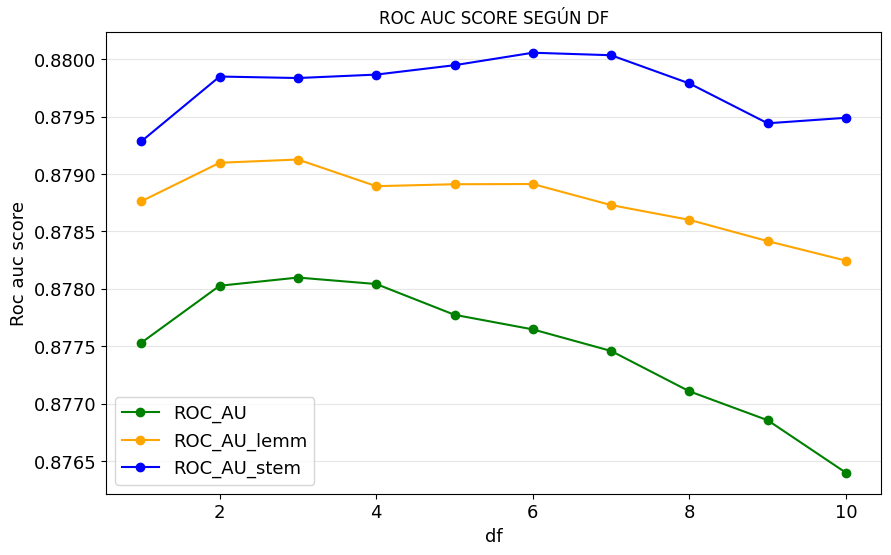

In [ ]:
# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(df_values, roc_auc_scores, linestyle='-', marker='o', color='green', label='ROC_AU')
plt.plot(df_values, roc_auc_scores_lemm, linestyle='-', marker='o', color='orange', label='ROC_AU_lemm')
plt.plot(df_values, roc_auc_scores_stem, linestyle='-', marker='o', color='blue', label='ROC_AU_stem')

# Añadir etiquetas de texto a cada punto en el gráfico
# for i, roc_auc in enumerate(roc_auc_scores):
#     plt.text(df_values[i], roc_auc, f"{roc_auc:.4f}", fontsize=10, verticalalignment='bottom', horizontalalignment='center')
# for i, roc_auc_lemm in enumerate(roc_auc_scores_lemm):
#     plt.text(df_values[i], roc_auc_lemm, f"{roc_auc_lemm:.4f}", fontsize=10, verticalalignment='top', horizontalalignment='center')
# for i, roc_auc_stem in enumerate(roc_auc_scores_stem):
#     plt.text(df_values[i], roc_auc_stem, f"{roc_auc_stem:.4f}", fontsize=10, verticalalignment='bottom', horizontalalignment='right')

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('df',fontsize=13)
plt.ylabel('Roc auc score', fontsize=13)
plt.title('ROC AUC SCORE SEGÚN DF')
plt.grid(axis='y', color='0.90')
plt.legend(loc='lower left', fontsize=13)
plt.show()

# Estrategia 2

## Preprocesamiento de embeddings

In [ ]:
# Función de preprocesamiento
stemmer = SnowballStemmer('english')

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())  # Convertir a minúsculas y tokenizar
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]  # Quitar puntuación y stopwords
    tokens = [stemmer.stem(token) for token in tokens] #Stemming
    return tokens

In [ ]:
# Preprocesar las tramas guardandolas en una columna dentro del df
dataTraining['tokens'] = dataTraining['plot'].apply(preprocess_text)

## Entrenamiento del Word2Vec

In [ ]:
#Entrenar el modelo Word2Vec
w2v_model = Word2Vec(sentences=dataTraining['tokens'], vector_size=200, window=5, min_count=1, workers=4)

In [ ]:
#Función que crear que promedia en un vector los vectores de las palabras de las tramas
def get_w2v_vector(tokens, model, vector_size):
    vec = np.zeros(vector_size)
    count = 0
    for word in tokens:
        if word in model.wv:
          vec += model.wv[word]
          count += 1
    if count != 0:
        vec /= count
    return vec

In [ ]:
# Obtener los vectores de Word2Vec para cada trama
dataTraining['w2v_vector'] = dataTraining['tokens'].apply(lambda x: get_w2v_vector(x, w2v_model, 200))

In [ ]:
X = np.array(dataTraining['w2v_vector'].tolist())

## Split en conjunto de entrenamiento y test

In [ ]:
# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X, y_genres, test_size=0.33, random_state=42)

## RandomForest

In [ ]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=200, max_depth=15, random_state=42))
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=15,
                                                     n_estimators=200,
                                                     n_jobs=-1,
                                                     random_state=42))

In [ ]:
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.7125711256467442

## Regresión logística

In [ ]:
clf = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42, n_jobs=-1))
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000, n_jobs=-1,
                                                 random_state=42))

In [ ]:
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')


0.7554080569614111

## XGBoost

In [ ]:
clf = OneVsRestClassifier(XGBClassifier(n_jobs=-1, n_estimators=200, max_depth=10, random_state=42, eval_metric='mlogloss'))
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=-1,
                                            num_parallel_tree=None,
                                            random_state=42, ...))

In [ ]:
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.7371292096071924

# Estrategia 3

## Entrenamiento con Universal Sentence Encoder (USE)

In [ ]:
# Asegúrate de que la versión de TensorFlow es compatible con TensorFlow Hub
print(tf.__version__)
print(hub.__version__)

2.17.0
0.16.1


In [ ]:
# URL del modelo USE
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"

In [ ]:
# Intentar cargar el modelo y manejar cualquier error
try:
    embed = hub.load(module_url)  # Cargar el modelo USE
except Exception as e:
    print("Error al cargar el modelo USE:", e)

In [ ]:
# Generar los embeddings para las tramas
def get_use_vector(text):
    try:
        text_vector = embed([text])  # Asegúrate de que se pasa como una lista
        return text_vector.numpy()[0]  # Devolver solo el primer vector
    except Exception as e:
        print("Error al obtener el vector para el texto:", text)
        print("Error:", e)
        return np.zeros((512,))  # Asegúrate de que el tamaño sea correcto

In [ ]:
dataTraining['use_vector'] = dataTraining['plot'].apply(get_use_vector)

In [ ]:
# Convertir los embeddings de USE en un array numpy
X = np.array(dataTraining['use_vector'].tolist())

## Split en conjunto de entrenamiento y test

In [ ]:
# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X, y_genres, test_size=0.33, random_state=42)

## RandomForest

In [ ]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=200, max_depth=15, random_state=42))
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=15,
                                                     n_estimators=200,
                                                     n_jobs=-1,
                                                     random_state=42))

In [ ]:
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.8468852083195014

## Regresión logística

In [ ]:
clf = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42, n_jobs=-1))
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000, n_jobs=-1,
                                                 random_state=42))

In [ ]:
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.8996034422260656

## XGBoost

In [ ]:
clf = OneVsRestClassifier(XGBClassifier(n_jobs=-1, n_estimators=200, max_depth=10, random_state=42, eval_metric='mlogloss'))
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=-1,
                                            num_parallel_tree=None,
                                            random_state=42, ...))

In [ ]:
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.8860899715553079